## Описание

Выполнили: Команда "Бобы" (Ерилов Юрий, Лепёха Алексей, Ленинг Денис)

Для предсказания используется CNN с 5 свёрточными слоями с разными размерами ядер, применяющихся непосредственно на эмбеддингах.

При подготовке ноутбука к отправке была найдена ошибка: 
 
 - В функции friend_preproc было упущено добавление токена слова при добавлении токена женского пола собеседника. 

Исправление данной ошибки улучшило итоговый score модели до 0.32507. Своевременное исправление ошибки могло бы дать нашей команде 6 место :(

В этом ноутбуке ошибка исправлена.

## Подключение kaggle и установка библиотек

In [ ]:
!pip install torchtext==0.9.1

In [ ]:
!pip install natasha

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
import json

data = {"username":"iuriierilov","key":"66fee5d328052d1dd8446849ea0ab6e9"}
with open('kaggle.json', 'w') as f:
    json.dump(data, f)

In [ ]:
 !mkdir -p ~/.kaggle
 !cp kaggle.json ~/.kaggle/
 !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c friends-classification
!mkdir data
!unzip friends-classification.zip -d data
!rm friends-classification.zip
!rm friends-classification.json

  0% 0.00/2.12M [00:00<?, ?B/s]
100% 2.12M/2.12M [00:00<00:00, 148MB/s]
Archive:  friends-classification.zip
  inflating: data/test.csv           
  inflating: data/train_data.csv     
  inflating: data/val_data.csv       
rm: cannot remove 'friends-classification.json': No such file or directory


In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

--2021-11-19 00:47:46--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  16.0MB/s    in 3.6s    

2021-11-19 00:47:51 (14.0 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]



## Подготовка

In [ ]:
import os
import math
import random
import string

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
import torch.optim

from tqdm.notebook import tqdm_notebook as tqdm
from tqdm.notebook import trange
from torch.utils.data import DataLoader
import torch.nn.functional as F
from navec import Navec
import razdel
import copy

In [ ]:
SEED = 1234


def enable_reproducibility(
        seed=SEED, raise_if_no_deterministic=True,
        cudnn_deterministic=True, disable_cudnn_benchmarking=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    torch.use_deterministic_algorithms(raise_if_no_deterministic)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    
    torch.backends.cudnn.benchmark = not disable_cudnn_benchmarking
    torch.backends.cudnn.deterministic = cudnn_deterministic

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
enable_reproducibility()

## Загрузка датасета

In [ ]:
train = pd.read_csv('data/train_data.csv', index_col=['Id']).rename(columns={'Category': 'label'})
val = pd.read_csv('data/val_data.csv', index_col=['Id'])
test = pd.read_csv('data/test.csv', index_col=['Id'])

In [ ]:
train.head(1)

,other_speaker,friend_response,label
Id,,,
0,Хорошо! Все в порядке! Достаточно! Достаточно!...,"Знаешь, я думаю, ты сможешь ее забрать.",ЧЕНДЛЕР


In [ ]:
import pymorphy2
import nltk

morph = pymorphy2.MorphAnalyzer()

In [ ]:
def friend_preproc(sentence):
  tokens = [_.text.lower() for _ in list(razdel.tokenize(str(sentence)))]

  final_sentence = []

  for i, token  in enumerate(tokens):
    token = morph.parse(token)[0]
    if 'NUMB' in token.tag:
      final_sentence.append('-NUMB-')
    elif token.tag.POS in ['VERB', 'ADJS', 'ADJF'] and token.tag.gender == 'femn' and (tokens[i - 2] == 'я' or tokens[i - 1] == 'я'):
      final_sentence.append('-FEM-')
      final_sentence.append(token.normal_form)
    elif token.tag.POS in ['VERB', 'ADJS', 'ADJF'] and token.tag.gender == 'femn' and (tokens[i - 2] == 'ты' or tokens[i - 1] == 'ты'):
      final_sentence.append('-FEM-O')
      final_sentence.append(token.normal_form)
    else:
      final_sentence.append(token.normal_form)

  return final_sentence

def other_preproc(sentence):
  tokens = [_.text.lower() for _ in list(razdel.tokenize(str(sentence)))]

  final_sentence = []

  for i, token  in enumerate(tokens):
    token = morph.parse(token)[0]
    if 'NUMB' in token.tag:
      final_sentence.append('-NUMB-')
    elif token.tag.POS in ['VERB', 'ADJS', 'ADJF'] and token.tag.gender == 'femn' and (tokens[i - 2] == 'ты' or tokens[i - 1] == 'ты'):
      final_sentence.append('-FEM-')
      final_sentence.append(token.normal_form)
    elif token.tag.POS in ['VERB', 'ADJS', 'ADJF'] and token.tag.gender == 'femn' and (tokens[i - 2] == 'я' or tokens[i - 1] == 'я'):
      final_sentence.append('-FEM-O')
      final_sentence.append(token.normal_form)
    else:
      final_sentence.append(token.normal_form)

  return final_sentence

def gram_preproc(sentence):
  tokens = [_.text.lower() for _ in list(razdel.tokenize(str(sentence)))]

  final_sentence = []

  for _token in tokens:
    token = str(morph.parse(_token)[0].tag)[:4]
    if token in ['ADJS', 'COMP']:
      token = 'ADJF'
    if token == 'INFN':
      token = 'VERB'
    if token == 'PRTS':
      token = 'PRTF'
    if token == 'PNCT':
      token = _token
    if token not in ['LATN', 'ROMN', 'UNKN']:
      final_sentence.append(token)

  return final_sentence

In [ ]:
train['friend_response'][0]

'Знаешь, я думаю, ты сможешь ее забрать.'

In [ ]:
other_preproc('Знаешь, я думала, ты сможешь ее забрать.')

['знать',
 ',',
 'я',
 '-FEM-O',
 'думать',
 ',',
 'ты',
 'смочь',
 'она',
 'забрать',
 '.']

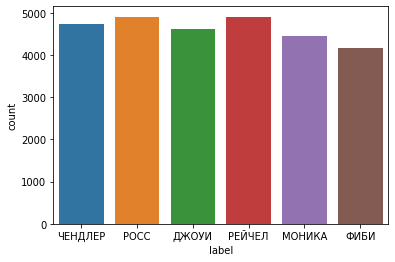

In [ ]:
sns.countplot(data=pd.concat([train, val], axis=0), x='label')

In [ ]:
train['gram_other_speaker'] = train['other_speaker'].apply(gram_preproc)
test['gram_other_speaker'] = test['other_speaker'].apply(gram_preproc)
val['gram_other_speaker'] = val['other_speaker'].apply(gram_preproc)

train['gram_friend_response'] = train['friend_response'].apply(gram_preproc)
test['gram_friend_response'] = test['friend_response'].apply(gram_preproc)
val['gram_friend_response'] = val['friend_response'].apply(gram_preproc)

train['friend_response'] = train['friend_response'].apply(friend_preproc)
test['friend_response'] = test['friend_response'].apply(friend_preproc)
val['friend_response'] = val['friend_response'].apply(friend_preproc)

train['other_speaker'] = train['other_speaker'].apply(other_preproc)
test['other_speaker'] = test['other_speaker'].apply(other_preproc)
val['other_speaker'] = val['other_speaker'].apply(other_preproc)

In [ ]:
from collections import Counter
from itertools import chain

from torchtext.vocab import Vocab

PAD_TOKEN = '<pad>'  # default special padding token in Vocab
UNK_TOKEN = '<unk>'  # default special token for unknown tokens in Vocab

words_counter = Counter(chain.from_iterable(map(lambda w: w.lower(), words) for words in 
                                            pd.concat([train['other_speaker'], train['friend_response'], 
                                            val['other_speaker'], val['friend_response'], 
                                            train['gram_other_speaker'], train['gram_friend_response'],
                                            val['gram_other_speaker'], val['gram_friend_response']], axis=0)))
words_vocab = Vocab(words_counter, min_freq=2,  specials=(PAD_TOKEN, UNK_TOKEN))

PAD_IDX = words_vocab.stoi[PAD_TOKEN]

print(f"Unique tokens in words vocabulary: {len(words_vocab)}")
print(words_vocab.itos[:200])

Unique tokens in words vocabulary: 10801
['<pad>', '<unk>', ',', 'verb', '.', 'noun', 'npro', 'conj', 'prcl', 'adjf', 'prep', 'advb', '!', '?', 'я', 'что', 'это', 'не', 'ты', 'в', 'вы', 'intj', 'и', 'быть', 'pred', 'мы', 'с', 'он', 'знать', 'она', 'мочь', 'на', 'у', 'о', 'как', 'нет', 'хорошо', 'да', 'так', 'мой', 'а', 'просто', 'но', 'хотеть', 'всё', 'они', '?!', 'ну', 'думать', 'бы', 'сказать', 'ладный', 'этот', 'если', 'есть', 'numr', 'сделать', '-', 'чтобы', 'должный', 'тот', 'иметь', 'делать', 'когда', 'prtf', 'привет', 'который', 'росс', ':', 'ой', 'потому', 'вид', 'ага', 'для', 'ещё', 'за', 'говорить', 'из', 'эй', 'почему', 'хороший', 'очень', 'здесь', 'только', 'свой', 'то', 'понимать', 'парень', 'такой', 'твой', 'весь', 'один', 'по', '…', 'к', 'бог', '-numb-', 'numb', 'действительно', 'ребята', 'нужно', 'видеть', 'большой', 'моника', 'дело', 'вот', 'кто', 'чем', 'чендлера', 'послушать', 'давать', 'джоуя', 'теперь', 'человек', 'пойти', 'рэйчел', 'друг', 'день', 'фиби', '-fem-',

### Инициализация эмбеддингов

In [ ]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
embed_weights = [[]] * len(words_vocab)
navec_indices = []

for i in range(len(words_vocab)):
  token = words_vocab.itos[i]
  try:
    embed_weights[i] = navec[token]
    navec_indices.append(i)
  except:
    embed_weights[i] = np.random.uniform(-1,1,300)

navec_indices = torch.LongTensor(navec_indices)
embed_weights = torch.tensor(embed_weights, requires_grad=True, dtype=torch.float32)

In [ ]:
embed_weights.shape

torch.Size([10801, 300])

In [ ]:
navec_indices.shape

torch.Size([9598])


Посмотрим с насколько большими предложениями мы имеем дело

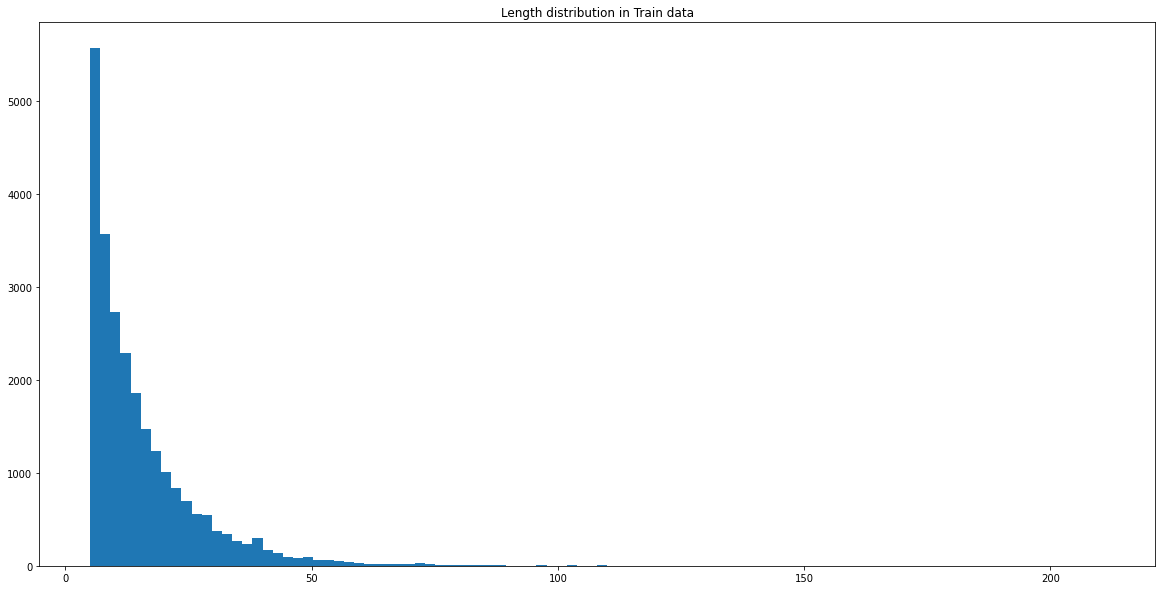

In [ ]:
lengths = map(lambda words_tags: len(words_tags), train['friend_response'])

plt.figure(figsize=[20, 10])
plt.title("Length distribution in Train data")
plt.hist(list(lengths), bins=100);

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [ ]:
train['label'] = le.transform(train['label'])
val['label'] = le.transform(val['label'])

In [ ]:
train_data = []
val_data = []
test_data = []
for i in range(len(train[['other_speaker', 'friend_response', 'label']])):
  train_data.append(list(train[['other_speaker', 'friend_response', 'label']].iloc[i]))

for i in range(len(val[['other_speaker', 'friend_response', 'label']])):
  val_data.append(list(val[['other_speaker', 'friend_response', 'label']].iloc[i]))

for i in range(len(test[['other_speaker', 'friend_response']])):
  test_data.append(list(test[['other_speaker', 'friend_response']].iloc[i]))

In [ ]:
print(train_data[0])

[['хорошо', '!', 'всё', 'в', 'порядок', '!', 'достаточно', '!', 'достаточно', '!', 'достаточно', '!', 'достаточно', '!', 'вы', 'двое', 'идти', 'домой', '!', 'я', 'должный', 'поговорить', 'с', 'жанин', '!'], ['знать', ',', 'я', 'думать', ',', 'ты', 'смочь', 'она', 'забрать', '.'], 5]


In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def tokens_transform(tokens):
    return [words_vocab.stoi[token] for token in tokens]

def tokens_inverse_transform(indexes):
    return [words_vocab.itos[idx] for idx in indexes]

def collate_batch(batch):
    labels_list, other_t_list, friend_t_list = [], [], []
    for friend_tokens, other_tokens, label in batch:
        labels_list.append(torch.tensor(label))
        friend_t_indices = tokens_transform(friend_tokens)
        other_t_indices = tokens_transform(other_tokens)

        friend_t_list.append(torch.tensor(friend_t_indices))
        other_t_list.append(torch.tensor(other_t_indices))
    return {
        "other_tokens": pad_sequence(other_t_list, batch_first=True, padding_value=PAD_IDX).int(),
        "friend_tokens": pad_sequence(friend_t_list, batch_first=True, padding_value=PAD_IDX).int(),
        "labels": torch.tensor(labels_list)
    }

#[BEG_TOKEN] + friend_tokens + [END_TOKEN]
#[BEG_TOKEN] + other_tokens + [END_TOKEN]

def test_collate_batch(batch):
    other_t_list, friend_t_list = [], []
    for friend_tokens, other_tokens in batch:
        friend_t_indices = tokens_transform(friend_tokens)
        other_t_indices = tokens_transform(other_tokens)

        friend_t_list.append(torch.tensor(friend_t_indices))
        other_t_list.append(torch.tensor(other_t_indices))
    return {
        "other_tokens": pad_sequence(other_t_list, batch_first=True, padding_value=PAD_IDX).int(),
        "friend_tokens": pad_sequence(friend_t_list, batch_first=True, padding_value=PAD_IDX).int()
    }

In [ ]:
BATCH_SIZE = 32

train_val_loader = DataLoader(train_data + val_data, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
valid_loader = DataLoader(val_data, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=test_collate_batch, shuffle=False)

In [104]:
def training(model, criterion, optimizer, num_epochs, train_loader, valid_loader, sheduler=None, max_grad_norm=2, freezing_epochs=0):
    for e in trange(num_epochs, leave=False):
        model.train()
        num_iter = 0
        train_loss = 0
        correct = 0
        num_objs = 0
        pbar = tqdm(train_loader, leave=False)
        for batch in pbar:
            try:
              optimizer.zero_grad()
              input_embeds = (batch["other_tokens"].to(device), batch["friend_tokens"].to(device))
              labels = batch["labels"].to(device)
              prediction = model(input_embeds)
              loss = criterion(prediction, labels)
              loss.backward()
              if e < freezing_epochs:
                  model.embedding.weight.grad[navec_indices] = 0

              if max_grad_norm is not None:
                  torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            except: RuntimeError

            optimizer.step()
            train_loss += loss
            correct += (labels == prediction.argmax(-1)).float().sum()
            num_objs += len(labels)
            num_iter += 1
        
        train_acc = correct/num_objs
        print(f"Epoch: {e}")
        print(f"Train Loss: {train_loss / num_iter}, accuracy: {train_acc}")

        valid_loss = 0
        num_iter = 0
        model.eval()
        with torch.no_grad():
            correct = 0
            num_objs = 0
            for batch in valid_loader:
                try:
                  input_embeds = (batch["other_tokens"].to(device), batch["friend_tokens"].to(device))
                  labels = batch["labels"].to(device)
                  prediction = model(input_embeds)
                  valid_loss += criterion(prediction, labels)
                  correct += (labels == prediction.argmax(-1)).float().sum()
                  num_objs += len(labels)
                  num_iter += 1
                except: RuntimeError

        if sheduler is not None:
          sheduler.step()

        valid_acc = correct/num_objs
        print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {valid_acc}")

    return train_acc, valid_acc

In [105]:
class Subset():
    """
    Subset of a dataset at specified indices.
    Arguments:
        dataset: The whole Dataset
        indices (sequence): Indices in the whole set selected for subset
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        if self.indices.shape == ():
            print('this happens: Subset')
            return 1
        else:
            return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


def KFold_validation(model, criterion, num_epochs, dataset, freezing_epochs=0, k=5):

  num_val_samples = len(dataset) // k
  train_acc = np.array([])
  val_acc = np.array([])

  initial_state = copy.deepcopy(model.state_dict())

  for i in range(k):
      print('Processing fold: ', i + 1)

      """%%%% Initiate new model %%%%""" #in every fold
      model.load_state_dict(initial_state)
      optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
      sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

      if i < k - 1:
        valid_idx = np.arange(len(dataset))[i * num_val_samples:(i + 1) * num_val_samples]
        train_idx = np.concatenate([np.arange(len(dataset))[:i * num_val_samples], np.arange(len(dataset))[(i + 1) * num_val_samples:]], axis=0)
      else:
        valid_idx = np.arange(len(dataset))[i * num_val_samples:]
        train_idx = np.arange(len(dataset))[:i * num_val_samples]

      train_dataset = Subset(dataset, train_idx)
      valid_dataset = Subset(dataset, valid_idx)
      train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
      valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=False)

      t_acc, v_acc = training(model, criterion, optimizer, num_epochs, train_loader, valid_loader, sheduler=sheduler, freezing_epochs=2)
      train_acc = np.append(train_acc, t_acc.cpu())
      val_acc = np.append(val_acc, v_acc.cpu())

  model.load_state_dict(initial_state)

  return train_acc, val_acc

## CNN 5

In [106]:
class CNN_5(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
        dropout=0.2,
        embed_weight=None
    ):
        super().__init__()
        if embed_weight == None:
          self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = PAD_IDX)
        else:
          self.embedding = nn.Embedding.from_pretrained(embed_weight, freeze=False, padding_idx=0)

        self.conv_0_1 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[0])
        self.conv_1_1 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[1])
        self.conv_2_1 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[2])
        self.conv_3_1 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[3])
        self.conv_4_1 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[4])

        self.conv_0_2 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[0])
        self.conv_1_2 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[1])
        self.conv_2_2 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[2])
        self.conv_3_2 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[3])
        self.conv_4_2 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[4])

        self.fc_1 = nn.Linear(len(kernel_sizes) * out_channels, len(kernel_sizes) * out_channels)
        self.fc_2 = nn.Linear(len(kernel_sizes) * out_channels, len(kernel_sizes) * out_channels)

        self.dropout = nn.Dropout(dropout)

        self.classifier = nn.Sequential(
            nn.Linear(len(kernel_sizes) * out_channels * 2, 
                      len(kernel_sizes) * out_channels * 2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(len(kernel_sizes) * out_channels * 2),
            nn.Linear(len(kernel_sizes) * out_channels * 2, 6)
        )
        
    def forward(self, texts):
        text1, text2 = texts[0], texts[1]
        embedded = self.embedding(text1)
        embedded = embedded.permute(0, 2, 1)
        
        conved_0_2 = F.leaky_relu(self.conv_0_2(embedded))
        conved_1_2 = F.leaky_relu(self.conv_1_2(embedded))
        conved_2_2 = F.leaky_relu(self.conv_2_2(embedded))
        conved_3_2 = F.leaky_relu(self.conv_3_2(embedded))
        conved_4_2 = F.leaky_relu(self.conv_4_2(embedded))

        pooled_0_2 = F.max_pool1d(conved_0_2, conved_0_2.shape[2]).squeeze(2)
        pooled_1_2 = F.max_pool1d(conved_1_2, conved_1_2.shape[2]).squeeze(2)
        pooled_2_2 = F.max_pool1d(conved_2_2, conved_2_2.shape[2]).squeeze(2)
        pooled_3_2 = F.max_pool1d(conved_3_2, conved_3_2.shape[2]).squeeze(2)
        pooled_4_2 = F.max_pool1d(conved_4_2, conved_4_2.shape[2]).squeeze(2)

        embedded = self.embedding(text2)
        embedded = embedded.permute(0, 2, 1)
        
        conved_0_1 = F.leaky_relu(self.conv_0_1(embedded))
        conved_1_1 = F.leaky_relu(self.conv_1_1(embedded))
        conved_2_1 = F.leaky_relu(self.conv_2_1(embedded))
        conved_3_1 = F.leaky_relu(self.conv_3_1(embedded))
        conved_4_1 = F.leaky_relu(self.conv_4_1(embedded))

        pooled_0_1 = F.max_pool1d(conved_0_1, conved_0_1.shape[2]).squeeze(2)
        pooled_1_1 = F.max_pool1d(conved_1_1, conved_1_1.shape[2]).squeeze(2)
        pooled_2_1 = F.max_pool1d(conved_2_1, conved_2_1.shape[2]).squeeze(2)
        pooled_3_1 = F.max_pool1d(conved_3_1, conved_3_1.shape[2]).squeeze(2)
        pooled_4_1 = F.max_pool1d(conved_4_1, conved_4_1.shape[2]).squeeze(2)

        cat = self.dropout(torch.cat((F.leaky_relu(self.fc_1(torch.cat((pooled_0_1, pooled_1_1, pooled_2_1, pooled_3_1, pooled_4_1), dim=1))),
                                      F.leaky_relu(self.fc_2(torch.cat((pooled_0_2, pooled_1_2, pooled_2_2, pooled_3_2, pooled_4_2), dim=1)))), dim=1))
        
        return self.classifier(cat)

In [107]:
enable_reproducibility()

kernel_sizes = [1, 2, 3, 4, 5]
vocab_size = len(words_vocab)
out_channels = 64
dropout = 0.2
dim = 300

model = CNN_5(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, dropout=dropout, embed_weight=embed_weights)

## Training


Подсчитаем количество обучаемых параметров нашей модели

In [108]:
def count_parameters(model):
    return sum(map(lambda x: x.numel(), model.parameters()))

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,437,746 trainable parameters


In [109]:
model.to(device)

CNN_5(
  (embedding): Embedding(10801, 300, padding_idx=0)
  (conv_0_1): Conv1d(300, 64, kernel_size=(1,), stride=(1,))
  (conv_1_1): Conv1d(300, 64, kernel_size=(2,), stride=(1,))
  (conv_2_1): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (conv_3_1): Conv1d(300, 64, kernel_size=(4,), stride=(1,))
  (conv_4_1): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (conv_0_2): Conv1d(300, 64, kernel_size=(1,), stride=(1,))
  (conv_1_2): Conv1d(300, 64, kernel_size=(2,), stride=(1,))
  (conv_2_2): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (conv_3_2): Conv1d(300, 64, kernel_size=(4,), stride=(1,))
  (conv_4_2): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (fc_1): Linear(in_features=320, out_features=320, bias=True)
  (fc_2): Linear(in_features=320, out_features=320, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=640, out_features=640, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm

In [110]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 6

In [ ]:
enable_reproducibility(raise_if_no_deterministic=False)
train_acc, val_acc = KFold_validation(model, criterion, num_epochs, train_data + val_data, freezing_epochs=2, k=9)
enable_reproducibility()

print()
print('valid_mean - {}, train_mean - {}'.format(np.mean(val_acc), np.mean(train_acc)))

## Сабмит

### Тренировка новой модели

In [ ]:
enable_reproducibility(raise_if_no_deterministic=False)
training(model, criterion, optimizer, num_epochs, train_val_loader, train_val_loader, sheduler=sheduler, freezing_epochs=2)
enable_reproducibility()

### Загрузка готовой модели

In [117]:
from google.colab import drive
drive.mount('/content/drive')

model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/not_init_6_epochs_train_val_set' +
'_initialized_embeds_freeze_navec_2_epochs_out_channels_64_dropout_02_adamw_cnn_5_fem_o_tokens_steplr_5.pt'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

### Предсказание

In [ ]:
preds = []
with torch.no_grad():
    for batch in test_loader:
        input_embeds = (batch["other_tokens"].to(device), batch["friend_tokens"].to(device))
        prediction = model(input_embeds)
        for p in prediction.argmax(-1):
          preds.append(int(p))

In [ ]:
submit = copy.deepcopy(test)

In [ ]:
submit['Category'] = le.inverse_transform(np.array(preds))

In [ ]:
submit.head()

,other_speaker,friend_response,gram_other_speaker,gram_friend_response,Category
Id,,,,,
0,"[но, я, безработный, ,, мой, музыка, -, это, в...","[я, застрелить, ., любой, совет, ?]","[CONJ, NPRO, NOUN, ,, ADJF, NOUN, -, PRCL, PRC...","[NPRO, VERB, ., ADJF, NOUN, ?]",МОНИКА
1,"[посмотреть, ., пятьсот, семнадцать, коробка, !]","[бог, мой, ,, как, ты, это, сделать, ?]","[VERB, ., NUMR, NUMR, NOUN, !]","[NOUN, ADJF, ,, CONJ, NPRO, PRCL, VERB, ?]",ЧЕНДЛЕР
2,"[хорошо, ., хорошо, ., помочь, бы, ,, если, бы...","[это, быть, бы, очень, полезно, !]","[ADVB, ., ADVB, ., VERB, PRCL, ,, CONJ, PRCL, ...","[PRCL, VERB, PRCL, ADVB, ADVB, !]",РЕЙЧЕЛ
3,"[росс, ,, что, ты, так, долго, ?]","[простить, ,, это, как, будто, не, для, быстры...","[NOUN, ,, NPRO, NPRO, CONJ, ADVB, ?]","[VERB, ,, PRCL, CONJ, CONJ, PRCL, PREP, ADJF, ...",РОСС
4,"[так, кто, ты, ?]","[ну, ,, наш, имя, действительно, моника, и, че...","[CONJ, NPRO, NPRO, ?]","[PRCL, ,, ADJF, NOUN, ADVB, NOUN, CONJ, NOUN, ...",РЕЙЧЕЛ


In [ ]:
submit['Category'].to_csv('submit.csv')

In [ ]:
torch.save(model.state_dict(), 'not_init_6_epochs_train_val_set_initialized_embeds_freeze_navec_2_epochs_out_channels_64_dropout_02_adamw_cnn_5_fem_o_tokens_steplr_5.pt')